# <img style="float: left; padding-right: 10px; width: 45px" src="https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/iacs.png"> Data Science 2: Advanced Topics in Data Science 

## Homework 2: Bayesian Analysis



**Harvard University**<br/>
**Spring 2022**<br/>
**Instructors**: Mark Glickman & Pavlos Protopapas


<hr style="height:2pt">

In [1]:
# RUN THIS CELL 
import requests
from IPython.core.discondplay import HTML
styles = requests.get(
    "https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/"
    "content/styles/cs109.css"
).text
HTML(styles)

ModuleNotFoundError: No module named 'IPython.core.discondplay'

<a id="instructions"></a>

<hr style="height:2pt">

### INSTRUCTIONS

- This homework can be submitted **in pairs**.

- To submit your assignment follow the instructions given in Canvas.

- Please **restart the kernel and run the entire notebook again before you submit. But remember that it can take a long time to run, so give yourself enough time.** 

- Running cells out of order is a common pitfall in Jupyter Notebooks. To make sure your code continues to work, restart the kernel and rerun your notebook periodically while working through this assignment. 

- We have tried to include all the libraries you may need to do the assignment in the imports cell provided below. **Please use only the libraries provided in those imports.**

- Please use `.head(...)` when viewing data. Do not submit a notebook that is **excessively long**. 

- In questions that require code to answer, such as "calculate and report $R^2$", do not just output the value from a cell. Write a `print(...)` function that clearly labels the output, includes a reference to the calculated value, and rounds it to a reasonable number of digits. **Do not hard code values in your printed output**. For example, this is an appropriate print statement:
```python
print(f'The R^2 is {R:.4f}')
```
- **Your plots MUST be clearly labeled and easy to read,** including clear labels for the $x$ and $y$ axes, a descriptive title ("MSE plot" is NOT a descriptive title; "Training and validation MSE at varying degree polynomial regression models" on the other hand is descriptive), a legend when appropriate, and clearly formatted text and graphics.

- **Your code may also be evaluated for efficiency and clarity.** As a result, correct output is not always sufficient for full credit.

<hr style="height:2pt">

In [2]:
import random
from datetime import datetime as dt

import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc3 as pm
from scipy.special import expit

%matplotlib inline

print(f"Using PyMC3 version: {pm.__version__}")
print(f"Using ArviZ version: {az.__version__}")

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Using PyMC3 version: 3.11.4
Using ArviZ version: 0.11.2


In [3]:
# Ignore a common pymc3 warning that comes from library functions, not our code.
# Pymc3 may throw additional warnings, but other warnings should be manageable
# by following the instructions included within the warning messages.
import warnings

messages=[
    "Using `from_pymc3` without the model will be deprecated in a future release",
]

for m in messages:
    warnings.filterwarnings("ignore", message=m)
    

<a id="contents"></a>

## Notebook Contents

- [**Part 1: Rejection sampling and the weighted bootstrap**](#part1)
  - [Overview](#part1intro)
  - [Questions](#part1questions)
  - [Solutions](#part1solutions)


- [**Part 2: Bayesian Logistic Regression and Varying-Intercepts Model**](#part2)
  - [Overview](#part2intro)
  - [Questions](#part2questions)
  - [Solutions](#part2solutions)


- [**Part 3: Varying-Coefficients Model and Model Selection**](#part3)
  - [Overview](#part3intro)
  - [Questions](#part3questions)
  - [Solutions](#part3solutions)


## Dataset Information

### Contraceptive Usage by Bangladeshi Women

For this assignment, you are provided with data sets `dataset_2_train.csv` and `dataset_2_test.csv`containing details of contraceptive usage by 1,934 Bangladeshi women.

There are four attributes for each woman, along with a label `contraceptive_use` indicating if she uses contraceptives. The attributes include:

* `district`: identifying code for the district the woman lives in
* `urban`: type of region of residence
* `living.children`: number of living children
* `age-mean`: age of the woman (in years, centered around mean)

The women are grouped into 60 districts. The task is to build a classification model that can predict if a given woman uses contraceptives.


<a id="part1"></a>
    
<!-- <div class="alert alert-block alert-danger" style="color:black;background-color:#E7F4FA"> -->

# Part 1:  Rejection sampling and the weighted bootstrap

[Return to contents](#contents)

<a id="part1intro"></a>

## Overview 

[Return to contents](#contents)

For the first part of the problem, we will only work with the label `contraceptive_use` and ignore all the attributes.  Let $Y_i$ be 1 if woman $i$ uses contraceptives, and 0 otherwise.  Assume a Bernoulli model for the data:

$$Y_{i} \sim \text{Bernoulli}(\theta)$$

where $i=1,\ldots,N$, with $N$ being the number of observations in the training data set, and $\theta$ is the unknown probability a woman uses contraception.  We will assume the following prior distribution on $\theta$:

$$\theta \sim \text{Normal}(0.5, 0.5^2)$$

subject to $0 \leq \theta \leq 1$.  This is sometimes called a truncated normal distribution.  A value from this distribution can be randomly drawn by simulating a value from $\text{Normal}(0.5, 0.5^2)$ and then keeping it if the value is between 0 and 1, and trying again if it is outside this range.  In fact, this is a form of rejection sampling.  The density for the truncated normal distribution is

$$p(\theta) = c\times\frac{1}{\sqrt{2\pi (0.5)^2}} \: \exp\left(\frac{-1}{2(0.5)^2}(\theta-0.5)^2\right) \; \text{for} \; 0\leq \theta \leq 1 \; \text{, and} \; 0 \; \text{otherwise,}$$

where $c$ is a normalizing constant that does not depend on $\theta$.

<a id="part1questions"></a>

### <div class='exercise'>Part 1: Questions</div> 

[Return to contents](#contents)

**1.1** Given the training data, what is the likelihood function $L(\theta | y_1,\ldots,y_n)$?  What is the MLE of $\theta$ as a function of the $y_1,\ldots,y_n$?  Compute the MLE from the data.

**1.2** Using rejection sampling, simulate a sample of 10,000 accepted values $\theta$ from the posterior distribution.  Plot a histogram of these values, and provide numerical summaries of the distribution of the 10,000 values. Interpret your findings.

**Note: make sure $\theta$ only takes on values which are valid for the parameter it represents and that all samples that do not pass the sampling criterion are rejected. Consult the lecture notes on rejection sampling if you need to review this criterion.**

**1.3** Carry out the weighted bootstrap to simulate 1,000 values of $\theta$ from the posterior distribution.  In doing so, simulate 10,000 values from the prior distribution to use as the discrete distribution from which the posterior draws will be simulated via the importance weights.  As above, plot a histogram of these values, and provide numerical summaries of the distribution of 1,000 values.  Interpret the results, and compare to the results of rejection sampling.


<a id="part1solutions"></a>

## Part 1: Solutions

[Return to contents](#contents)

### Helper Functions


In [27]:
from scipy import stats
def read_data(filename = 'data/dataset_2_train.csv', train = True):
    if train:
        data = pd.read_csv(filename)
    return data


def trunc_normal(n = 10, mean = 0.5, std_dev = 0.5, min = 0, max = 1):
    '''
    Returns n from a normal distribution ~N(mean, std_dev^2) truncated between min and max
    '''
    x_trunc = []
    while len(x_trunc) < n:
        x = np.random.normal(loc=mean, scale = std_dev)
        if (x >=min and x<=max):
            x_trunc.append(x)
        
    if len(x_trunc) == 1:
        return x_trunc[0]
    
    return x_trunc



<div class='exercise-r'>

**1.1.a**  Given the training data, what is the likelihood function $L(\theta | y_1,\ldots,y_n)$?  



</div>

#### Answer

Per the problem statement:
$$
Y_i = 
\begin{cases}
1    &\text {if the $i$-th woman uses contraceptives} \\
0 & \text {otherwise}
\end{cases}
$$

We know that the probability model for a Bernoulli distribution is as follows:


$$
P(Y_i = y | \theta)=
\begin{cases}
\theta    &\text {for } y = 1\\
1 - \theta & \text {for } y=0\\
\end{cases}
$$

Equivalent to:
\begin{aligned}
P(Y_i = y | \theta)
&= \theta^{y_i} (1-\theta)^{1-y_i}
\end{aligned}

Where $\theta$ is the unknown probability a woman uses contraception.

We get the likelihood function by calculating the probability of the data conditional on $\theta$, viewed as a function of the parameter:
\begin{aligned}
L(\theta | y_1, y_2, ... , y_n)
&=p(y_1, y_2, ... , y_n | \theta)\\
&= P(Y_1 = y_1 | \theta) \cdot P(Y_2 = y_2 | \theta) \cdot \ldots P(Y_n = y_n | \theta) \\ 
&= \prod_{i=1}^n P(Y_i = y_i | \theta) \\
&= \prod_{i=1}^n\theta^{y_i}  (1-\theta)^{1-y_i}
\end{aligned}



<div class='exercise-r'>

**1.1.b**   What is the MLE of $\theta$ as a function of the $y_1,\ldots,y_n$?  Compute the MLE from the data.

</div>


#### Answer
We will take the log of $L(\theta | y_1, y_2, ... , y_n)$ because it simplifies working with the expression:

\begin{aligned}
\ln({L(\theta | y_1, y_2, ... , y_n)})
&= \ln \left(\prod_{i=1}^n\ \theta^{y_i}  (1-\theta)^{1-y_i}  \right)\\
&= \sum_{i=1}^n \left[ y_i \ln{\theta} + (1-y_i) \ln{(1-\theta)} \right]\\
&=  \left(y_1 \ln(\theta) + (1-y_1) \ln(1-\theta) \right)  + \ldots + \left( y_n \ln(\theta) + (1-y_n) \ln(1-\theta) \right)\\
&=(y_1 + y_2 + ... + y_n)  \cdot \ln(\theta) + [n - (y_1 + y_2 + ... + y_n)]\cdot \ln(1-\theta) 
\end{aligned}


Letting $Y_i = (y_1 + y_2 + ... + y_n)$: 
\begin{aligned}
\ln({L(\theta | Y_i)}) 
&=(Y_i)  \cdot \ln(\theta) + [n - Y_i]\cdot \ln(1-\theta) 
\end{aligned}

The MLE is occurs at a value of \theta where:

\begin{aligned}
0  
&= \frac{d\ln({L(\theta | Y_i)}}{d\theta} \\
&=\frac{d} {d\theta} \left[(Y_i)  \cdot \ln(\theta) + [n - Y_i]\cdot \ln(1-\theta) \right] \\ 0
&=  \frac{Y_i}{\theta} - \frac{n - Y_i}{1-\theta} 
\end{aligned}

Finally we solve for $\theta_{MLE}$:
$$
\theta_{MLE} = \frac{Y_i}{n} = \frac{y_1 + y_2 + ... + y_n} {n}
$$ 


<div class='exercise-r'>

**1.1.c**   Compute the MLE from the data.

</div>

In [5]:
df = read_data()
n = df.shape[0]
y_i = df['contraceptive_use'].sum()
mle = y_i/n
print(f'The MLE is {mle:.4f}')

The MLE is 0.3899


<div class='exercise-r'>

**1.2**  Using rejection sampling, simulate a sample of 10,000 accepted values $\theta$ from the posterior distribution.  Plot a histogram of these values, and provide numerical summaries of the distribution of the 10,000 values. Interpret your findings.

**Note: make sure $\theta$ only takes on values which are valid for the parameter it represents and that all samples that do not pass the sampling criterion are rejected. Consult the lecture notes on rejection sampling if you need to review this criterion.**



</div>

Data has 967 rows
Alpha = 378
Beta = 591


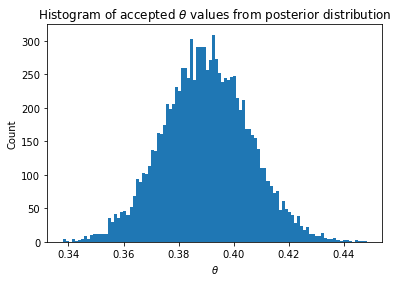

Summary of 10,000 sampled and accepted values of $\theta$
 - Mean = 0.38994
 - Variance = 0.00024
 - Std. Dev = 0.01562
 - Median = 0.38980


In [6]:
def L(theta, alpha, beta):
    l = (theta**(alpha-1)) * ((1-theta)**(beta-1))
    return l

df = read_data()
n = df.shape[0]
mle = y_i/n
y_i = df['contraceptive_use'].sum()

alpha, beta = (y_i+1, n-y_i + 1)


print("Data has {} rows".format(n))
print("Alpha = {}".format(alpha))
print("Beta = {}".format(beta))

samples = 10000 # number of samples to draw
mu, sigma = (0.5, 0.5)
M  = L(mle, alpha, beta)
thetas = []

while len(thetas) <samples:
    # simulate theta from p(theta)
    
    theta = trunc_normal(n = 1, mean = mu, std_dev = sigma, min = 0, max = 1)
    
    # generate U from uniform distribution
    U = np.random.uniform(0, 1)
    
    # likelihood
    likelihood = L(theta, alpha, beta)
    likelihood_M = likelihood/M
    
    # acceptance check
    accept = likelihood_M >= U

    if accept:
        thetas.append(theta)

thetas = np.array(thetas)
plt.hist(thetas, bins = 100)
plt.ylabel('Count')
plt.xlabel('$\\theta$')
plt.title('Histogram of accepted $\\theta$ values from posterior distribution')
plt.show()

mean = thetas.mean()
var = thetas.var()
std = thetas.std()
median = np.median(thetas)
print('Summary of 10,000 sampled and accepted values of $\\theta$')
print(' - Mean = {:.5f}'.format(mean))
print(' - Variance = {:.5f}'.format(var))
print(' - Std. Dev = {:.5f}'.format(std))
print(' - Median = {:.5f}'.format(median))

These simulated results, drawn from the posterior distribution, suggest that the probability that a woman uses contraception is closer to 0.39 than to the 0.5 initially assumed in the prior distribution $\theta$. 
Our prior distribution should be updated to $\theta \sim \text{Normal}(0.39, 0.015^2)$

<div class='exercise-r'>

**1.3**  Carry out the weighted bootstrap to simulate 1,000 values of $\theta$ from the posterior distribution.  In doing so, simulate 10,000 values from the prior distribution to use as the discrete distribution from which the posterior draws will be simulated via the importance weights.  As above, plot a histogram of these values, and provide numerical summaries of the distribution of 1,000 values.  Interpret the results, and compare to the results of rejection sampling.


</div>

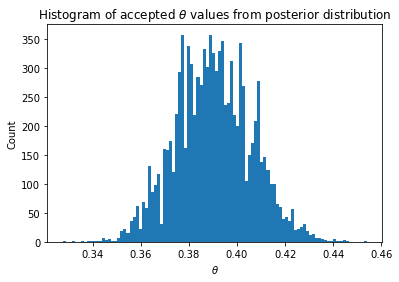

Summary of 10,000 sampled and accepted values of $\theta$
 - Mean = 0.39028
 - Variance = 0.00025
 - Std. Dev = 0.01572


In [7]:
import random
samples = 10000 # number of samples to draw
mu, sigma = (0.5, 0.5)
thetas = np.array(trunc_normal(n = samples, mean = mu, std_dev = sigma, min = 0, max = 1))
likelihood = L(thetas, alpha, beta)
weights = likelihood/likelihood.sum()
v = random.choices(thetas,weights=weights,k=samples)

thetas = np.array(v)
plt.hist(thetas, bins = 100)
plt.ylabel('Count')
plt.xlabel('$\\theta$')
plt.title('Histogram of accepted $\\theta$ values from posterior distribution')
plt.show()

mean = thetas.mean()
var = thetas.var()
std = thetas.std()
median = np.median(thetas)
print('Summary of 10,000 sampled and accepted values of $\\theta$')
print(' - Mean = {:.5f}'.format(mean))
print(' - Variance = {:.5f}'.format(var))
print(' - Std. Dev = {:.5f}'.format(std))

As with the rejection sampling, with the bootstrap approach we find that the probability that a woman uses contraception is closer to 0.39 than to the 0.5 initially assumed in the prior distribution $\theta$. The only noticeable difference in the statistics is a slight change in the standard deviation, implying that the bootstrap method brings more uncertainty.
Our prior distribution should be updated to $\theta \sim \text{Normal}(0.39, 0.016^2)$

<a id="part2"></a>
    
<!-- <div class="alert alert-block alert-danger" style="color:black;background-color:#E7F4FA"> -->

# Part 2: Bayesian Logistic Regression and Varying-Intercepts Model

[Return to contents](#contents)



<a id="part2intro"></a>

## Overview 

[Return to contents](#contents)

The second model we will fit to the contraceptives data is a varying-intercept logistic regression model, where the intercept varies by district.

Prior distributions:

$$
\begin{split}
\beta_{0j} &\sim N(\mu_0,\sigma_0^2)\; \text{, with} \;\; \mu_0 \sim N(0,10000)\; \text{and} \; \; \frac{1}{\sigma^2_0} \sim \text{Gamma}(0.1,0.1)
\\
\beta_1 &\sim N(0,10000) 
\\ \\ 
\beta_2 &\sim N(0,10000)
\\ \\ 
\beta_3 &\sim N(0,10000)
\\ \\
\end{split}
$$

Model for data:

$$
\begin{split}
Y_{ij} & \sim \text{Bernoulli}(p_{ij})
\\ \\
\text{logit}\:p_{ij} &= \beta_{0j} + \beta_1 \times \text{urban} + \beta_2 \times \text{living.children} + \beta_3 \times \text{age-mean}
\\ \\
\end{split}
$$

Where $Y_{ij}$ is 1 if woman $i$ in district $j$ uses contraceptives, and 0 otherwise, and where $i \in \{1,...,N\}$ and $j \in \{1,...,J\}$. $N$ is the number of observations in the data, and $J$ is the number of districts. The above notation assumes $N(\mu, \sigma^2)$ is a Normal distribution with mean $\mu$ and variance $\sigma^2$.

**PLEASE NOTE:** The $\text{Gamma}$ distribution cited above, uses the $\text{Gamma}(\alpha, \beta)$ parametrization, where $\alpha$ is the shape and $\beta$ is the rate.  

<a id="part2questions"></a>

### <div class='exercise'>Part 2: Questions</div> 

[Return to contents](#contents)


**2.1** As a preprocessing step, map the district number 61 to the number 54 so that the numbering is consecutive with no gaps. Also, re-name district 60 to be district 0 so that the districts are now numbered 0 through 59. **We use this numbering throughout the homework, and will grade using these district numbers**

**2.2** We should verify that pymc3 can indeed recover the hidden parameter values. To do this, we'll hard-code known values of our choosing for the model parameters and simulate data from the model. Then, using this simulated data, we'll check if pymc3 can get back the parameter values we hard-coded. If it does, we'll have hope that it can get the hidden parameter values that generated the real data.

**Note: These hard-coded parameters will be used in question 2.2 - 2.5**.

Use the following hard-coded values:

$$
\begin{split}
\mu_0 &= 2
\\ \\
\sigma^2_0 &= 1
\\ \\
\beta_{0j} &\sim N(\mu_0,\sigma_0^2) \; \text{for all sixty districts}
\\ \\
\beta_1 &= 4
\\ \\ 
\beta_2 &= -3
\\ \\
\beta_3 &= -2
\\ \\
\end{split}
$$

**Verify that these parameters generate data in which an average of 46 to 48 percent of subjects use contraceptives.**

**2.3** Fit the varying-intercept model specified above to your simulated data. Reasonably good convergence may require adjustments to the number of tuning samples and the target acceptance rate as suggested in pymc3's warnings.

**2.4** Plot the trace plots of the MCMC sampler for the parameters $\mu_0, \frac{1}{\sigma^2_0}\text{ (a.k.a., }\tau_0\text{)}, \beta_1, \beta_2, \beta_3$. Based on these and the R-hat values, does it look like the samplers converged?

**2.5** Plot histograms of the posterior distributions for the parameters $\beta_{0,9}$, $\beta_{0,19}$, $\beta_{0,29}$, ..., $\beta_{0,59}$. Are the actual parameters that you generated contained within these posterior distributions?

**Hint: The `az.plot_posterior()` function might be helpful here.**

**2.6** We now fit our model to the *actual* data. Fit the varying-intercept model to the real training data.

**2.7** Check the convergence by examining the trace plots and R-hats, as you did with the simulated data. What do you observe?

**2.8** Based on the posterior means, which district has the highest base rate of contraceptive usage (independent of other factors like urban population)? Which district has the lowest?

**2.9** What are the posterior means of $\mu_0$ and $\sigma_0$? Do these values offer any evidence in support of or against the varying-intercept model, compared to a model with a single intercept value for all districts?

<a id="part2solutions"></a>

## Part 2: Solutions

[Return to contents](#contents)

<div class='exercise-r'>

**2.1**  As a preprocessing step, map the district number 61 to the number 54 so that the numbering is consecutive with no gaps. Also, re-name district 60 to be district 0 so that the districts are now numbered 0 through 59. **We use this numbering throughout the homework, and will grade using these district numbers**



</div>

In [24]:
def read_data_part2():
    # your code here
    df = read_data()

    # map district 61 to 54
    df['district'] = df['district'].replace(61,54)

    # rename district 60 to 0
    df['district'] = df['district'].replace(60,0)
    
    return df

data = read_data_part2()

(967, 5)

<div class='exercise-r'>

**2.2**  We should verify that pymc3 can indeed recover the hidden parameter values. To do this, we'll hard-code known values of our choosing for the model parameters and simulate data from the model. Then, using this simulated data, we'll check if pymc3 can get back the parameter values we hard-coded. If it does, we'll have hope that it can get the hidden parameter values that generated the real data.

**Note: These hard-coded parameters will be used in question 2.2 - 2.5**.

Use the following hard-coded values:

$$
\begin{split}
\mu_0 &= 2
\\ \\
\sigma^2_0 &= 1
\\ \\
\beta_{0j} &\sim N(\mu_0,\sigma_0^2) \; \text{for all sixty districts}
\\ \\
\beta_1 &= 4
\\ \\ 
\beta_2 &= -3
\\ \\
\beta_3 &= -2
\\ \\
\end{split}
$$

**Verify that these parameters generate data in which an average of 46 to 48 percent of subjects use contraceptives.**

$\text{logit}\:p_{ij} = \beta_{0j} + \beta_1 \times \text{urban} + \beta_2 \times \text{living.children} + \beta_3 \times \text{age-mean}$



</div>

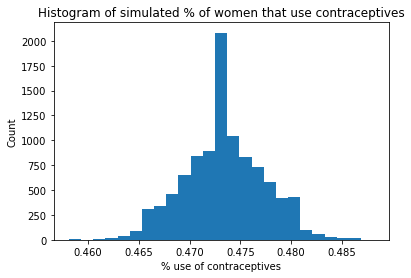

Summary of 10,000 simulations of contraceptive use
 - Mean = 0.47341
 - Variance = 0.00002
 - Std. Dev = 0.00395


In [128]:
def logit(logit_p):
    p = 1/(1 + np.exp(-logit_p))
    return p

data = read_data_part2()


# Hard coded values
mu_0 = 2
var_0 = 1
sigma_0 = np.sqrt(var_0)
data['beta_0'] = pd.Series(np.ones(data.shape[0]))

betas = []
for i in range(60):
    betas.append(np.random.normal(mu_0, var_0))
    
for idx, beta in enumerate(betas):
    data.loc[df['district'] == idx, 'beta_0'] = betas[idx]


beta = [0, 4, -3, -2]

samples = data.shape[0]

beta_0 = data['beta_0']
urban = data['urban']
living_children = data['living.children'] 
age_mean = data['age_mean']

ratio = []
for i in range(10000):
    logit_p = beta_0 + beta[1]*urban + beta[2]*living_children + beta[3]*age_mean
    p = logit(logit_p)
    Y = [np.random.binomial(1, pij) for pij in p]
    ratio.append(sum(Y)/len(Y))
    
ratio = np.array(ratio)
plt.hist(ratio, bins = 25)
plt.ylabel('Count')
plt.xlabel('% use of contraceptives')
plt.title('Histogram of simulated % of women that use contraceptives')
plt.show()


mean = ratio.mean()
var = ratio.var()
std = ratio.std()
median = np.median(ratio)
print('Summary of 10,000 simulations of contraceptive use')
print(' - Mean = {:.5f}'.format(mean))
print(' - Variance = {:.5f}'.format(var))
print(' - Std. Dev = {:.5f}'.format(std))



<div class='exercise-r'>

**2.3**  Fit the varying-intercept model specified above to your simulated data. Reasonably good convergence may require adjustments to the number of tuning samples and the target acceptance rate as suggested in pymc3's warnings.


$$
\begin{split}
\beta_{0j} &\sim N(\mu_0,\sigma_0^2)\; \text{, with} \;\; \mu_0 \sim N(0,10000)\; \text{and} \; \; \frac{1}{\sigma^2_0} \sim \text{Gamma}(0.1,0.1)
\\
\beta_1 &\sim N(0,10000) 
\\ \\ 
\beta_2 &\sim N(0,10000)
\\ \\ 
\beta_3 &\sim N(0,10000)
\\ \\
\end{split}
$$

Model for data:

$$
\begin{split}
Y_{ij} & \sim \text{Bernoulli}(p_{ij})
\\ \\
\text{logit}\:p_{ij} &= \beta_{0j} + \beta_1 \times \text{urban} + \beta_2 \times \text{living.children} + \beta_3 \times \text{age-mean}
\\ \\
\end{split}
$$

</div>

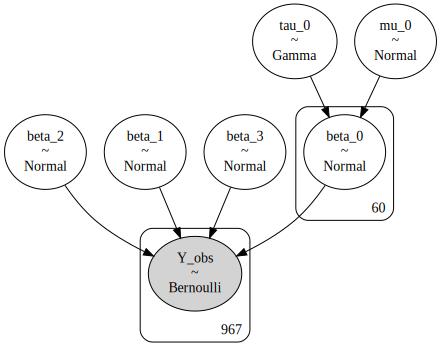

In [142]:
# your code here
from pymc3 import Model, Normal, HalfNormal, model_to_graphviz
from pymc3 import NUTS, sample, find_MAP
from scipy import optimize

data = read_data_part2()
  
    
# probability model
sigma = np.sqrt(10000)
with Model() as my_linear_model:
    mu_0 = pm.Normal('mu_0', mu=0, sd = sigma)
    tau_0 = pm.Gamma('tau_0', alpha=0.1, beta=0.1)
    
    beta_0 = pm.Normal('beta_0', mu=mu_0, tau=tau_0, shape=60)
    beta_1 = pm.Normal('beta_1', mu=0, sd=sigma)
    beta_2 = pm.Normal('beta_2', mu=0, sd=sigma)
    beta_3 = pm.Normal('beta_3', mu=0, sd=sigma)
    
    logit_p = beta_0[data['district'].values] + beta_1*data['urban'].values + beta_2*data['living.children'].values + beta_3*data['age_mean'].values
    p = logit(logit_p)
    Y_obs = pm.Bernoulli(name = 'Y_obs', logit_p=logit_p, observed = Y)

model_to_graphviz(my_linear_model) 
    
    

<div class='exercise-r'>

**2.4**  Plot the trace plots of the MCMC sampler for the parameters $\mu_0, \frac{1}{\sigma^2_0}\text{ (a.k.a., }\tau_0\text{)}, \beta_1, \beta_2, \beta_3$. Based on these and the R-hat values, does it look like the samplers converged?



</div>

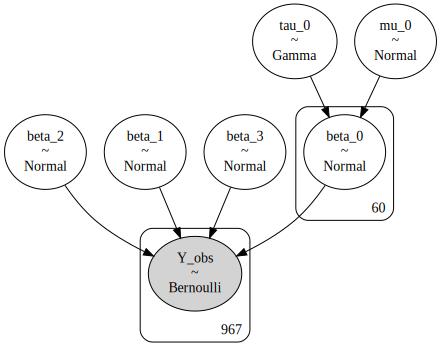

In [140]:
# your code here

**your answer here**

<div class='exercise-r'>

**2.5**  Plot histograms of the posterior distributions for the parameters $\beta_{0,9}$, $\beta_{0,19}$, $\beta_{0,29}$, ..., $\beta_{0,59}$. Are the actual parameters that you generated contained within these posterior distributions?

**Hint: The `az.plot_posterior()` function might be helpful here.**



</div>

In [ ]:
# your code here



**your answer here**

<div class='exercise-r'>

**2.6**  We now fit our model to the *actual* data. Fit the varying-intercept model to the real training data.



</div>

In [ ]:
# your code here



<div class='exercise-r'>

**2.7**  Check the convergence by examining the trace plots and R-hats, as you did with the simulated data. What do you observe?



</div>

In [ ]:
# your code here



**your answer here**

<div class='exercise-r'>

**2.8**  Based on the posterior means, which district has the highest base rate of contraceptive usage (independent of other factors like urban population)? Which district has the lowest?



</div>

In [ ]:
# your code here



**your answer here**

<div class='exercise-r'>

**2.9**  What are the posterior means of $\mu_0$ and $\sigma_0$? Do these values offer any evidence in support of or against the varying-intercept model, compared to a model with a single intercept value for all districts?

</div>

In [ ]:
# your code here



**your answer here**

<a id="part3"></a>
    
<!-- <div class="alert alert-block alert-danger" style="color:black;background-color:#E7F4FA"> -->

# Part 3: Varying-Coefficients Model and Model Selection

[Return to contents](#contents)


<a id="part3intro"></a>

## Overview 

[Return to contents](#contents)

The next model we will fit to the contraceptives data is a varying-coefficients logistic regression model, where the coefficients on `living.children`, `age_mean`, and `urban` vary by district.

Prior distribution:

$$
\begin{split}
\beta_{0j} &\sim N(\mu_0,\sigma_0^2)\; \text{, with} \;\; \mu_0 \sim N(0,10000)\; \text{and} \; \; \frac{1}{\sigma^2_0} \sim \text{Gamma}(0.1,0.1)
\\
\beta_{1j} &\sim N(0,\sigma_1^2)\; \text{, with} \;\; \frac{1}{\sigma^2_1} \sim \text{Gamma}(0.1,0.1) 
\\
\beta_{2j} &\sim N(0,\sigma_2^2)\; \text{, with} \;\; \frac{1}{\sigma^2_2} \sim \text{Gamma}(0.1,0.1)
\\ 
\beta_{3j} &\sim N(0,\sigma_3^2)\; \text{, with} \;\; \frac{1}{\sigma^2_3} \sim \text{Gamma}(0.1,0.1)
\\
\end{split}
$$

Model for data:

$$
\begin{split}
Y_{ij} &\sim \text{Bernoulli}(p_{ij})
\\ \\
\text{logit}\:p_{ij} &= \beta_{0j} + \beta_{1j} \times \text{urban} + \beta_{2j} \times \text{living.children} + \beta_{3j} \times \text{age-mean}
\\ \\
\end{split}
$$

**PLEASE NOTE:** Once again, the $\text{Gamma}$ distribution uses the $\text{Gamma}(\alpha, \beta)$ parametrization, where $\alpha$ is the shape and $\beta$ is the rate. 

<a id="part3questions"></a>

### <div class='exercise'>Part 3: Questions</div> 

[Return to contents](#contents)

**3.1** Fit the varying-coefficients model described above to the real training data.

**3.2** Check the convergence of your varying-coefficients model by examining the trace plots and R-hats, as you did with the prior varying-intercepts model. What do you observe?

**3.3** Plot the distributions of posterior means and credible intervals for each predictor's coefficient by district. What do you conclude from these graphs?

**HINT:** The ArviZ [`plot_forest()`](https://arviz-devs.github.io/arviz/api/generated/arviz.plot_forest.html) function is very well-suited for this task.

**3.4** Use all of the information you've gleaned thus far to build Bayesian logistic regression classifiers for both your varying-intercepts model (from 2.7) and your varying-coefficients model (from 3.1). Then, use each model to make predictions on your training and test sets.

  - Report each model's classification percentages and accuracy scores on both the training and test sets, as well as the trivial accuracy scores you would achieve with a "naive" model that predicts only the most frequent outcome observed in your training data.
  
  
  - What do you observe from these results?
  
  
  - Which model appears to be the best (i.e. varying-intercept or varying-coefficient), and what is your rationale?

<a id="part3solutions"></a>

## Part 3: Solutions

[Return to contents](#contents)

<div class='exercise-r'>

**3.1**  Fit the varying-coefficients model described above to the real training data.



</div>

In [ ]:
# your code here



<div class='exercise-r'>

**3.2**  Check the convergence of your varying-coefficients model by examining the trace plots and R-hats, as you did with the prior varying-intercepts model. What do you observe?



</div>

In [ ]:
# your code here



**your answer here**

<div class='exercise-r'>

**3.3**  Plot the distributions of posterior means and credible intervals for each predictor's coefficient by district. What do you conclude from these graphs?

**HINT:** The ArviZ [`plot_forest()`](https://arviz-devs.github.io/arviz/api/generated/arviz.plot_forest.html) function is very well-suited for this task.



</div>

In [ ]:
# your code here



**your answer here**

<div class='exercise-r'>

**3.4**  Use all of the information you've gleaned thus far to build Bayesian logistic regression classifiers for both your varying-intercepts model (from 2.7) and your varying-coefficients model (from 3.1). Then, use each model to make predictions on your training and test sets.

  - Report each model's classification percentages and accuracy scores on both the training and test sets, as well as the trivial accuracy scores you would achieve with a "naive" model that predicts only the most frequent outcome observed in your training data.
  
  
  - What do you observe from these results?
  
  
  - Which model appears to be the best (i.e. varying-intercept or varying-coefficient), and what is your rationale?

</div>

In [ ]:
# your code here



**your answer here**